Comment1: For this final project, we did the work between the two of us:

We both helped with the data loading and preprocessing, and also worked together on evaluating the models – that includes confusion matrices, performance metrics, and result visualizations.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Authors: Mengtian Lin & David Abiandu – Data loading and preprocessing


In [2]:
# =========================  Imports  =========================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report

# =========================  Path Setup  =========================
train_dir = '/content/drive/MyDrive/4801/Final/archive/train'
test_dir  = '/content/drive/MyDrive/4801/Final/archive/test'



In [3]:
# =========================  Data Transforms  =========================
# Train transforms: resize -> random augment -> tensor -> normalize
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Test transforms: only resize & normalize
test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])



In [4]:
# =========================  Datasets & Dataloaders  =========================
train_ds = datasets.ImageFolder(root=train_dir, transform=train_tfms)
test_ds  = datasets.ImageFolder(root=test_dir,  transform=test_tfms)

# ----------- NEW: use only a subset of the dataset -----------
subset_size_train = 1000
subset_size_test  = 300

train_indices = torch.randperm(len(train_ds))[:subset_size_train]
test_indices  = torch.randperm(len(test_ds))[:subset_size_test]

train_ds = torch.utils.data.Subset(train_ds, train_indices)
test_ds  = torch.utils.data.Subset(test_ds,  test_indices)
# -------------------------------------------------------------

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)


# Comment2:  Author: Mengtian Lin – Baseline CNN model definition and training

Mengtian Lin worked on the baseline CNN model – including writing the model code, training it, and plotting the loss and accuracy graphs.

In [5]:
# =========================  CNN Model  =========================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        # Classification head
        self.fc1   = nn.Linear(64 * 56 * 56, 128)
        self.drop  = nn.Dropout(0.5)
        self.fc2   = nn.Linear(128, 2)

    def forward(self, x):
        # Conv block 1
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)              # 224 → 112
        # Conv block 2
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)              # 112 → 56
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully-connected layers
        x = nn.functional.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to('cuda' if torch.cuda.is_available() else 'cpu')



In [ ]:
# =========================  Loss & Optimizer  =========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# =========================  Metric Containers (NEW)  =========================
train_loss_list, val_loss_list = [], []
train_acc_list,  val_acc_list  = [], []

# =========================  Training & Validation Loop  =========================
num_epochs = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss /= total

    # ---- Validation ----
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss /= total

    # ---- Epoch Summary ----
    print(f'Epoch [{epoch+1:02}/{num_epochs}]  '
          f'Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  '
          f'Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}')

    # ---- Record metrics for plotting (NEW) ----
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)


Epoch [01/20]  Train Loss: 1.2915  Train Acc: 0.6890  Val Loss: 0.4786  Val Acc: 0.7833
Epoch [02/20]  Train Loss: 0.5284  Train Acc: 0.7120  Val Loss: 0.4159  Val Acc: 0.7867
Epoch [03/20]  Train Loss: 0.4952  Train Acc: 0.7600  Val Loss: 0.4070  Val Acc: 0.7967
Epoch [04/20]  Train Loss: 0.4586  Train Acc: 0.7660  Val Loss: 0.3879  Val Acc: 0.7900
Epoch [05/20]  Train Loss: 0.4508  Train Acc: 0.7630  Val Loss: 0.3757  Val Acc: 0.7933
Epoch [06/20]  Train Loss: 0.4485  Train Acc: 0.7710  Val Loss: 0.3736  Val Acc: 0.8100
Epoch [07/20]  Train Loss: 0.4327  Train Acc: 0.7830  Val Loss: 0.3968  Val Acc: 0.8167
Epoch [08/20]  Train Loss: 0.4416  Train Acc: 0.7830  Val Loss: 0.3802  Val Acc: 0.8100
Epoch [09/20]  Train Loss: 0.4161  Train Acc: 0.7930  Val Loss: 0.3769  Val Acc: 0.8000
Epoch [10/20]  Train Loss: 0.3974  Train Acc: 0.7860  Val Loss: 0.3790  Val Acc: 0.8067
Epoch [11/20]  Train Loss: 0.4206  Train Acc: 0.7750  Val Loss: 0.3760  Val Acc: 0.8133
Epoch [12/20]  Train Loss: 0.417

# Authors: Mengtian Lin – Model evaluation and visualization


In [ ]:
# =================  Confusion Matrix & Report  =================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()   # get class with highest probability
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Get true class names (benign / malignant)
class_names = train_ds.dataset.classes

print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

# Print overall accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\nOverall Accuracy: {acc:.4f}")



Classification Report:
              precision    recall  f1-score   support

      benign       0.93      0.74      0.83       170
   malignant       0.73      0.93      0.82       130

    accuracy                           0.82       300
   macro avg       0.83      0.84      0.82       300
weighted avg       0.85      0.82      0.82       300


Overall Accuracy: 0.8233


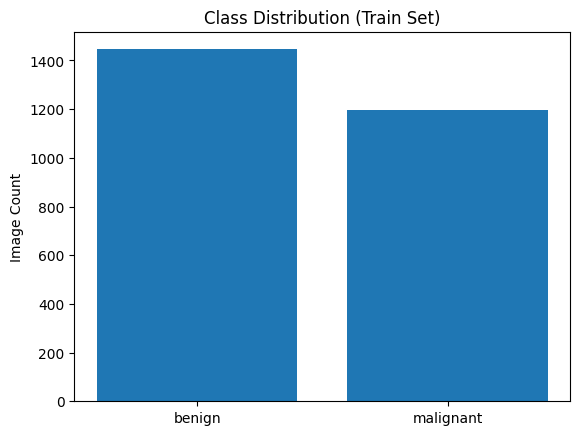

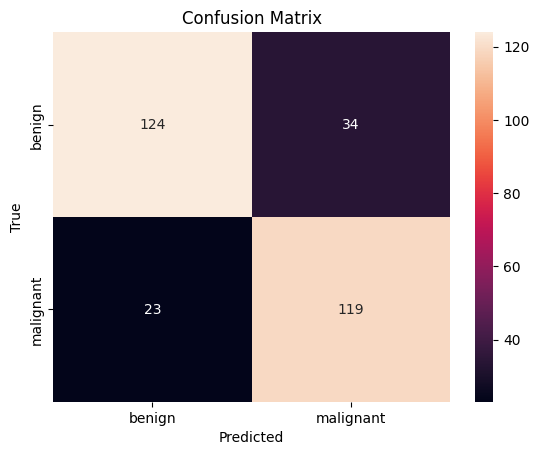

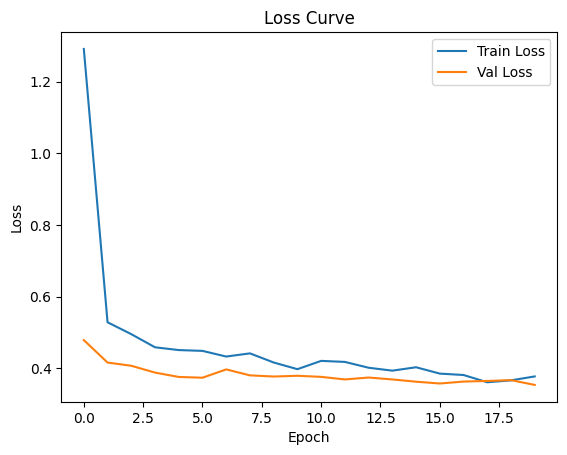

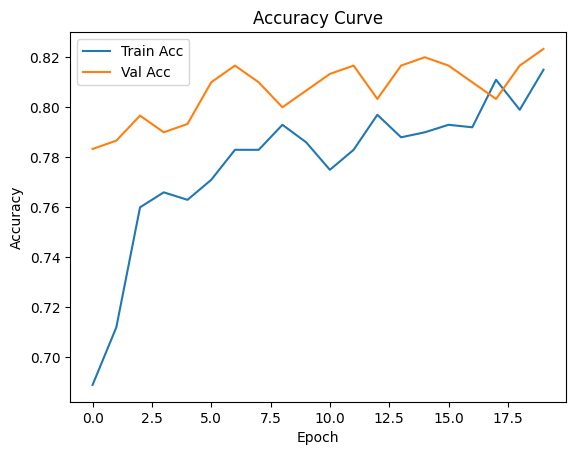

In [ ]:
#1) Category distribution bar chart
import matplotlib.pyplot as plt
from collections import Counter
from torchvision.datasets import ImageFolder

full_train = ImageFolder(train_dir)
labels = [label for _, label in full_train.imgs]
cnt = Counter(labels)
plt.bar(full_train.classes, [cnt[0], cnt[1]])
plt.title('Class Distribution (Train Set)')
plt.ylabel('Image Count')
plt.show()

# 2) Confusion Matrix Heat Map
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Loss curve
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve')
plt.legend(); plt.show()

# Accuracy curve
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list,   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve')
plt.legend(); plt.show()


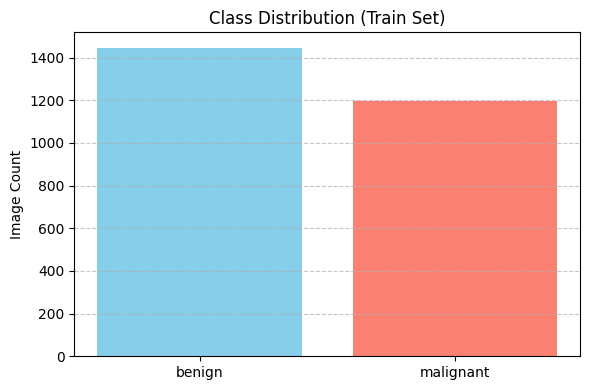

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from torchvision.datasets import ImageFolder

full_train = ImageFolder(train_dir)
labels = [label for _, label in full_train.imgs]
cnt = Counter(labels)

plt.figure(figsize=(6, 4))
plt.bar(full_train.classes, [cnt[0], cnt[1]], color=['skyblue', 'salmon'])
plt.title('Class Distribution (Train Set)')
plt.ylabel('Image Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


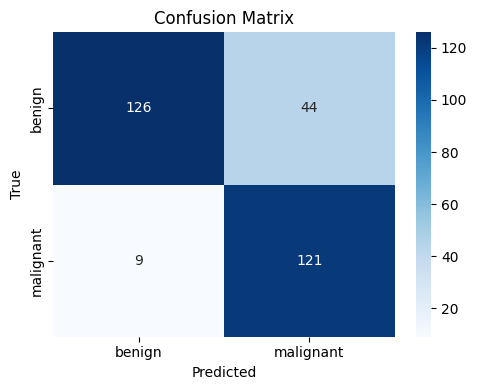

In [ ]:
import seaborn as sns
plt.figure(figsize=(5, 4))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.grid(False)
plt.tight_layout()
plt.show()


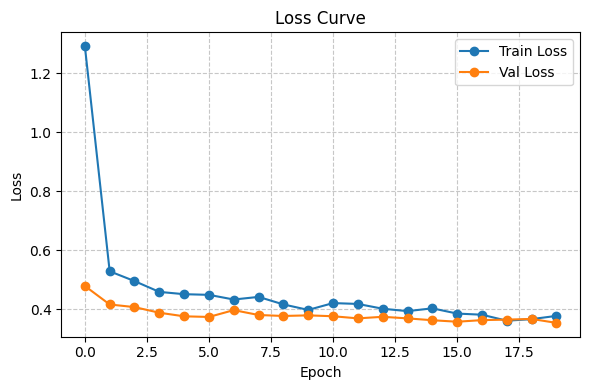

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_loss_list, label='Train Loss', marker='o')
plt.plot(val_loss_list,   label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


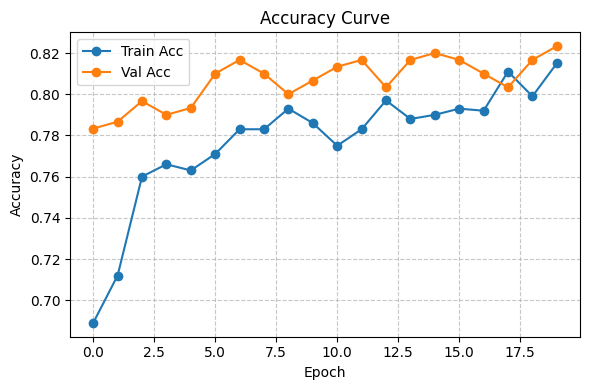

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_acc_list, label='Train Acc', marker='o')
plt.plot(val_acc_list,   label='Val Acc', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


**Class distribution and representative samples of benign and malignant lesions.**

Comment: We work together about this code.

The dataset contains two major classes: benign and malignant skin lesions. The left bar chart compares the image counts between the initial subset and the full dataset. While the subset was carefully balanced for preliminary training (≈ 500 samples per class), the full dataset exhibits mild class imbalance, with malignant images slightly outnumbering benign ones. The right panel displays randomly selected sample images from both classes and data splits, highlighting the visual diversity in texture, color, and shape. Such variability justifies the need for robust image preprocessing and augmentation.

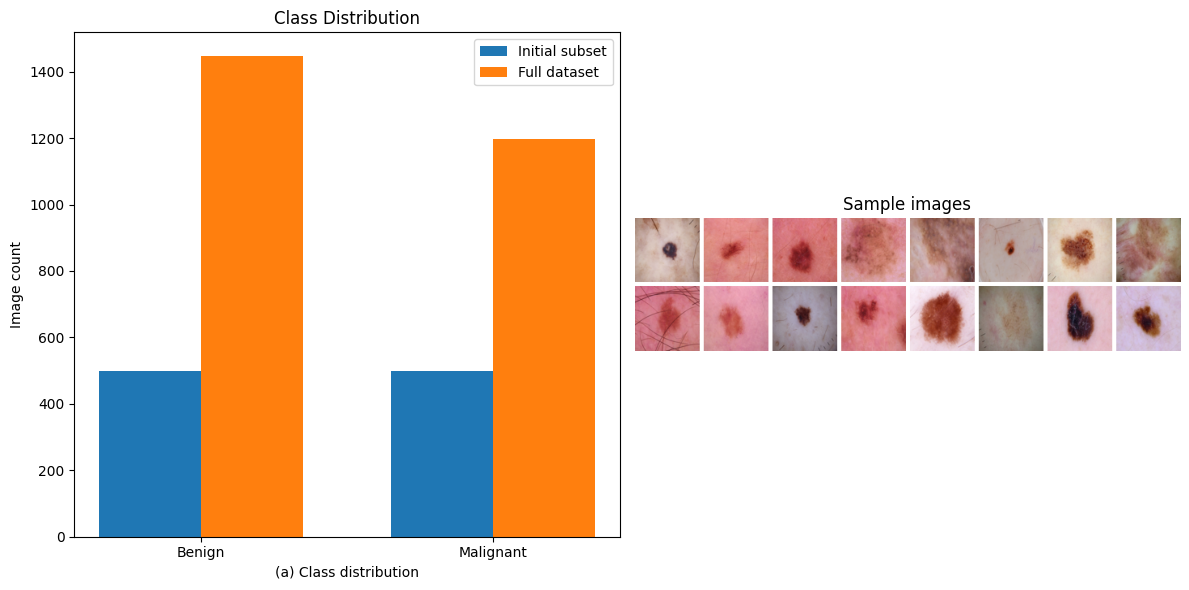

In [ ]:
# ====================== Imports ======================
import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ====================== Path config ===================
# TODO: replace with your actual training-folder path
TRAIN_DIR = '/content/drive/MyDrive/4801/Final/archive/train'

# how many thumbnails per class in each row
SAMPLES_PER_CLASS = 4
THUMB_SIZE        = (80, 80)   # width, height in pixels
PADDING           = 5          # white space between thumbnails

# ====================== Utility functions =============
def count_images_by_class(root):
    """Return a dict {class_name: image_count}."""
    return {
        cls: len([
            f for f in os.listdir(os.path.join(root, cls))
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        for cls in sorted(os.listdir(root))
    }

def random_image_paths(class_dir, n):
    """Randomly pick n image file paths from class_dir."""
    pool = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]
    return random.sample(pool, n)

def paste_row(canvas, paths, top):
    """Paste a list of images into canvas starting at vertical offset top."""
    left = 0
    for p in paths:
        img = Image.open(p).resize(THUMB_SIZE)
        canvas.paste(img, (left, top))
        left += THUMB_SIZE[0] + PADDING

# ====================== Prepare counts ================
full_counts = count_images_by_class(TRAIN_DIR)

# simulate initial-subset counts; adjust as needed
INITIAL_SUBSET_SIZE = 1000
subset_counts = dict(full_counts)          # copy keys
subset_counts['benign']     = INITIAL_SUBSET_SIZE // 2
subset_counts['malignant']  = INITIAL_SUBSET_SIZE - subset_counts['benign']

classes = list(full_counts.keys())         # e.g. ['benign', 'malignant']

# ====================== Build figure ==================
fig = plt.figure(figsize=(12, 6))

# ---- (a) class distribution bar chart ----
ax1 = fig.add_subplot(1, 2, 1)
x = np.arange(len(classes))
bar_w = 0.35
ax1.bar(x - bar_w/2, [subset_counts[c] for c in classes],
        width=bar_w, label='Initial subset')
ax1.bar(x + bar_w/2, [full_counts[c]   for c in classes],
        width=bar_w, label='Full dataset')
ax1.set_xticks(x)
ax1.set_xticklabels([c.capitalize() for c in classes])
ax1.set_ylabel('Image count')
ax1.set_title('Class Distribution')
ax1.legend()
ax1.set_xlabel('(a) Class distribution')

# ---- (b) sample image mosaic ----
ax2 = fig.add_subplot(1, 2, 2)
ax2.axis('off')
ax2.set_title('Sample images')

# build blank canvas
rows    = 2                                   # initial subset row + full dataset row
cols    = len(classes) * SAMPLES_PER_CLASS
canvas_w = cols * THUMB_SIZE[0] + (cols-1) * PADDING
canvas_h = rows * THUMB_SIZE[1] + (rows-1) * PADDING
canvas   = Image.new('RGB', (canvas_w, canvas_h), (255, 255, 255))

# row 0: initial subset
for i, cls in enumerate(classes):
    paths = random_image_paths(os.path.join(TRAIN_DIR, cls), SAMPLES_PER_CLASS)
    y     = 0
    x_off = i * (SAMPLES_PER_CLASS * (THUMB_SIZE[0] + PADDING))
    for j, p in enumerate(paths):
        img = Image.open(p).resize(THUMB_SIZE)
        canvas.paste(img, (x_off + j*(THUMB_SIZE[0]+PADDING), y))

# row 1: full dataset
for i, cls in enumerate(classes):
    paths = random_image_paths(os.path.join(TRAIN_DIR, cls), SAMPLES_PER_CLASS)
    y     = THUMB_SIZE[1] + PADDING
    x_off = i * (SAMPLES_PER_CLASS * (THUMB_SIZE[0] + PADDING))
    for j, p in enumerate(paths):
        img = Image.open(p).resize(THUMB_SIZE)
        canvas.paste(img, (x_off + j*(THUMB_SIZE[0]+PADDING), y))

ax2.imshow(canvas)
ax2.set_xlabel('(b) Sample images')

# ---------------- finalize figure ---------------------
plt.tight_layout()
plt.show()


#Comment3: Author: David Abiandu – VGG19+CBAM model definition and training

David Abiandu handled the VGG19 + CBAM model, which included adding the attention modules, running training, and saving the results.

In [ ]:
# =========================================================
# Step 1 : Path config  (EDIT your own paths)
# =========================================================
ROOT_DIR   = '/content/drive/MyDrive/4801/Final'
DATA_DIR   = f'{ROOT_DIR}/archive'
CBAM_DIR   = f'{ROOT_DIR}/CBAM-main'

TRAIN_DIR  = f'{DATA_DIR}/train'
TEST_DIR   = f'{DATA_DIR}/test'



In [ ]:
# =========================================================
# Step 2 : Imports  (torch, torchvision, etc.)
# =========================================================
import sys, torch, numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt


# =========================================================
# Step 3 : Data transforms
# =========================================================
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])



In [ ]:
# =========================================================
# Step 4 : Load ImageFolder + intercept subset
# =========================================================
train_ds = datasets.ImageFolder(root=TRAIN_DIR, transform=train_tfms)
test_ds  = datasets.ImageFolder(root=TEST_DIR,  transform=test_tfms)

subset_size_train, subset_size_test = 1000, 300
train_ds = Subset(train_ds, torch.randperm(len(train_ds))[:subset_size_train])
test_ds  = Subset(test_ds,  torch.randperm(len(test_ds))[:subset_size_test])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)



In [ ]:
# =========================================================
# Step 5 : Import CBAM directory & model
# =========================================================
sys.path.append(CBAM_DIR)
from vgg_cbam_model import VGG19

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = VGG19(in_channels=3, out_channels=2).to(device)   # 2 = benign / malignant



In [ ]:
# =========================================================
# Step 5.1 : Hot-patch CAM to fix missing attribute `linear`
# =========================================================
from vgg_cbam_model import CAM

patched = 0
for m in model.modules():
    if isinstance(m, CAM) and hasattr(m, 'linear_max') and not hasattr(m, 'linear'):
        m.linear = m.linear_max
        patched += 1

print(f'Patched CAM modules: {patched}')


Patched CAM modules: 5


In [ ]:
# =========================================================
# Step 6 : Loss, optimizer, training utilities
# =========================================================
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# lists for plotting
train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

In [ ]:
# =========================================================
# Step 7 : Training & validation loop (Test1)
# =========================================================
EPOCHS = 20
for ep in range(EPOCHS):
    # ---- train ----
    model.train()
    tr_loss, tr_correct, tr_total = 0, 0, 0
    for imgs, labs in train_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        outs = model(imgs)
        loss = criterion(outs, labs)
        loss.backward()
        optimizer.step()

        tr_loss += loss.item() * imgs.size(0)
        tr_correct += outs.argmax(1).eq(labs).sum().item()
        tr_total   += labs.size(0)
    tr_acc  = tr_correct / tr_total
    tr_loss /= tr_total

    # ---- validate ----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labs in test_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            outs = model(imgs)
            loss = criterion(outs, labs)

            val_loss += loss.item() * imgs.size(0)
            val_correct += outs.argmax(1).eq(labs).sum().item()
            val_total   += labs.size(0)
    val_acc  = val_correct / val_total
    val_loss /= val_total

    # ---- record & print ----
    train_loss_hist.append(tr_loss); val_loss_hist.append(val_loss)
    train_acc_hist.append(tr_acc);   val_acc_hist.append(val_acc)

    print(f'Epoch [{ep+1:02}/{EPOCHS}]  '
          f'TrainLoss {tr_loss:.4f}  TrainAcc {tr_acc:.4f}  '
          f'ValLoss {val_loss:.4f}  ValAcc {val_acc:.4f}')



Epoch [01/20]  TrainLoss 0.8717  TrainAcc 0.5380  ValLoss 0.7558  ValAcc 0.4300
Epoch [02/20]  TrainLoss 0.9577  TrainAcc 0.5060  ValLoss 0.6993  ValAcc 0.4300
Epoch [03/20]  TrainLoss 0.7822  TrainAcc 0.5450  ValLoss 0.7125  ValAcc 0.4300
Epoch [04/20]  TrainLoss 0.7812  TrainAcc 0.5230  ValLoss 0.7171  ValAcc 0.4300
Epoch [05/20]  TrainLoss 0.7748  TrainAcc 0.5000  ValLoss 0.6907  ValAcc 0.5700
Epoch [06/20]  TrainLoss 0.7239  TrainAcc 0.5210  ValLoss 0.6841  ValAcc 0.5700
Epoch [07/20]  TrainLoss 0.7536  TrainAcc 0.5160  ValLoss 0.6970  ValAcc 0.4300
Epoch [08/20]  TrainLoss 0.7503  TrainAcc 0.5130  ValLoss 0.6934  ValAcc 0.4300
Epoch [09/20]  TrainLoss 0.7136  TrainAcc 0.5220  ValLoss 0.7056  ValAcc 0.5700
Epoch [10/20]  TrainLoss 0.7028  TrainAcc 0.5260  ValLoss 0.6835  ValAcc 0.5700
Epoch [11/20]  TrainLoss 0.7256  TrainAcc 0.5340  ValLoss 0.6840  ValAcc 0.5700
Epoch [12/20]  TrainLoss 0.7312  TrainAcc 0.5350  ValLoss 0.6803  ValAcc 0.5767
Epoch [13/20]  TrainLoss 0.6944  TrainAc

In [ ]:
print(model.__class__)

<class 'vgg_cbam_model.VGG19'>


# Authors: David Abiandu – Model evaluation and visualization


In [ ]:
# =========================================================
# Step 7 : Training & validation loop (Test2)
# =========================================================
EPOCHS = 20
for ep in range(EPOCHS):
    # ---- train ----
    model.train()
    tr_loss, tr_correct, tr_total = 0, 0, 0
    for imgs, labs in train_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        outs = model(imgs)
        loss = criterion(outs, labs)
        loss.backward()
        optimizer.step()

        tr_loss += loss.item() * imgs.size(0)
        tr_correct += outs.argmax(1).eq(labs).sum().item()
        tr_total   += labs.size(0)
    tr_acc  = tr_correct / tr_total
    tr_loss /= tr_total

    # ---- validate ----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labs in test_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            outs = model(imgs)
            loss = criterion(outs, labs)

            val_loss += loss.item() * imgs.size(0)
            val_correct += outs.argmax(1).eq(labs).sum().item()
            val_total   += labs.size(0)
    val_acc  = val_correct / val_total
    val_loss /= val_total

    # ---- record & print ----
    train_loss_hist.append(tr_loss); val_loss_hist.append(val_loss)
    train_acc_hist.append(tr_acc);   val_acc_hist.append(val_acc)

    print(f'Epoch [{ep+1:02}/{EPOCHS}]  '
          f'TrainLoss {tr_loss:.4f}  TrainAcc {tr_acc:.4f}  '
          f'ValLoss {val_loss:.4f}  ValAcc {val_acc:.4f}')



Epoch [01/20]  TrainLoss 0.8975  TrainAcc 0.5160  ValLoss 0.7308  ValAcc 0.4300
Epoch [02/20]  TrainLoss 0.8959  TrainAcc 0.5270  ValLoss 0.7046  ValAcc 0.4300
Epoch [03/20]  TrainLoss 0.7819  TrainAcc 0.4840  ValLoss 0.6895  ValAcc 0.5700
Epoch [04/20]  TrainLoss 0.7872  TrainAcc 0.5320  ValLoss 0.7101  ValAcc 0.4300
Epoch [05/20]  TrainLoss 0.7934  TrainAcc 0.5150  ValLoss 0.6840  ValAcc 0.5700
Epoch [06/20]  TrainLoss 0.7321  TrainAcc 0.5170  ValLoss 0.7478  ValAcc 0.4300
Epoch [07/20]  TrainLoss 0.7676  TrainAcc 0.5170  ValLoss 0.6908  ValAcc 0.5700
Epoch [08/20]  TrainLoss 0.6392  TrainAcc 0.5980  ValLoss 0.4795  ValAcc 0.7433
Epoch [09/20]  TrainLoss 0.5941  TrainAcc 0.6970  ValLoss 0.4863  ValAcc 0.7667
Epoch [10/20]  TrainLoss 0.5600  TrainAcc 0.7340  ValLoss 0.4968  ValAcc 0.7600
Epoch [11/20]  TrainLoss 0.5093  TrainAcc 0.7600  ValLoss 0.4525  ValAcc 0.7733
Epoch [12/20]  TrainLoss 0.5018  TrainAcc 0.7570  ValLoss 0.4473  ValAcc 0.7367
Epoch [13/20]  TrainLoss 0.4663  TrainAc

In [ ]:
# =========================================================
# Step 8 : Final evaluation (classification report)
# =========================================================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        outs = model(imgs).argmax(1).cpu()
        all_preds.extend(outs.numpy())
        all_labels.extend(labs.numpy())

class_names = train_ds.dataset.classes
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("Overall Accuracy:", accuracy_score(all_labels, all_preds))



Classification Report:
              precision    recall  f1-score   support

      benign       0.91      0.78      0.84       163
   malignant       0.78      0.91      0.84       137

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.85      0.84      0.84       300

Overall Accuracy: 0.8366666666666667


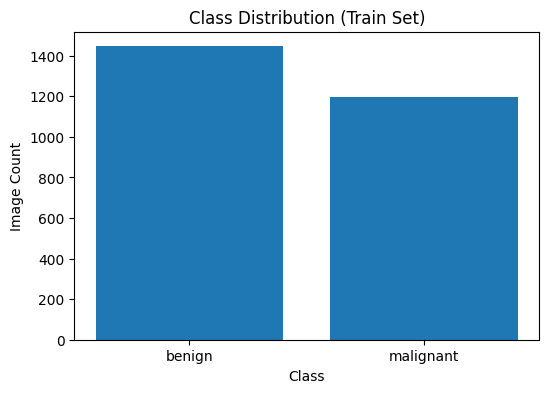

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from torchvision.datasets import ImageFolder

full_train = ImageFolder(TRAIN_DIR)

labels = [label for _, label in full_train.imgs]
cnt = Counter(labels)

plt.figure(figsize=(6,4))
plt.bar(full_train.classes, [cnt[0], cnt[1]])
plt.title('Class Distribution (Train Set)')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.show()


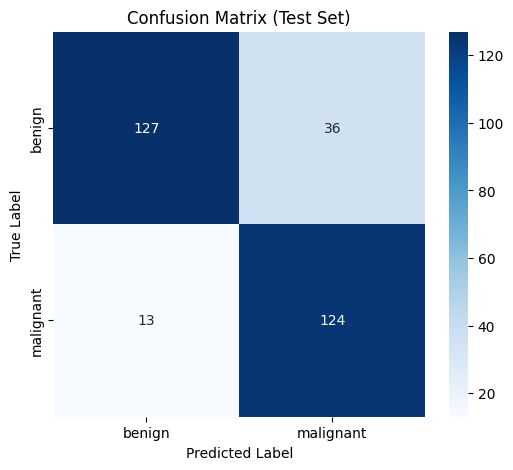

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


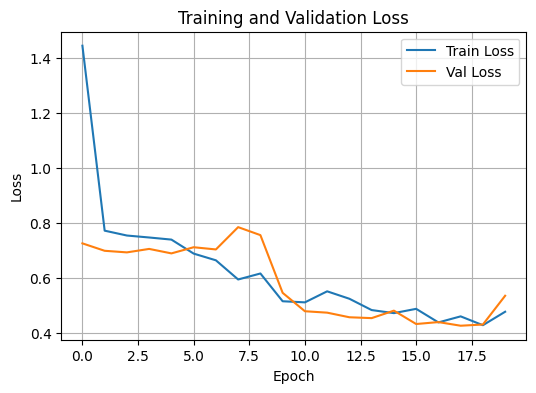

In [ ]:
# Loss curves
plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


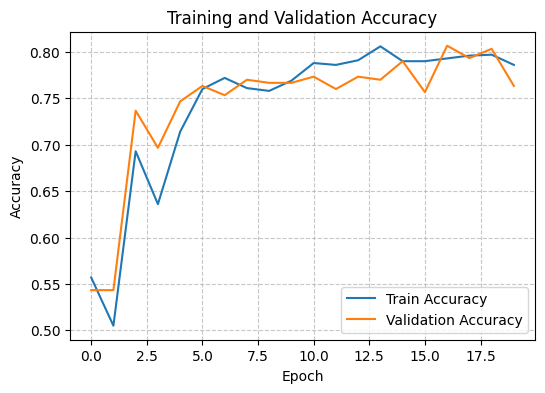

In [ ]:
# Plot training and validation Accuracy curves
plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist,   label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
